In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import nltk
import inflect
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nlp_surveillance.classifier import extract_sentence
from nlp_surveillance.pipeline import ExtractSentencesAndLabel, RecommenderLabeling, RecommenderTierAnnotation
from nlp_surveillance.classifier import summarize
from utils.my_utils import split_list_and_distribute_to_new_rows

# Count/Date Classifier: Most Informative Words

In [ ]:
df_sent = ExtractSentencesAndLabel('counts').data_output()
df_sent['sentence']= df_sent['sentence'].apply(lambda x: list(set(x.split()) - set(stopwords.words('english'))))
df_sent.head()

In [ ]:
df_sent = split_list_and_distribute_to_new_rows(df_sent, 'sentence')
df_sent.head()

In [ ]:
as_tuples = df_sent.apply(tuple, axis=1).tolist()
as_tuples = [({'word':word}, label) for label, word in as_tuples]
as_tuples

In [ ]:
clf = nltk.NaiveBayesClassifier.train(as_tuples)
clf.show_most_informative_features(20)

In [ ]:
df_sent_date = ExtractSentencesAndLabel('dates').data_output()
df_sent_date['sentence']= df_sent_date['sentence'].apply(lambda x: list(set(x.split()) - set(stopwords.words('english'))))
df_sent_date = split_list_and_distribute_to_new_rows(df_sent_date, 'sentence')
as_tuples_date = df_sent_date.apply(tuple, axis=1).tolist()
as_tuples_date = [({'sent':word}, label) for label, word in as_tuples_date]

In [ ]:
clf_date = nltk.NaiveBayesClassifier.train(as_tuples_date)
clf_date.show_most_informative_features(20)

# Recommendation Classifier

In [ ]:
df_recommand = RecommenderLabeling().data_output()

In [ ]:
df_tiers = RecommenderTierAnnotation().data_output()

In [ ]:
df_tiers.head()

In [ ]:
df_clf = pd.concat([df_recommand, df_tiers],axis=1, ignore_index=False)

In [ ]:
df_clf = df_clf.dropna()

In [ ]:
df_clf['counts'] = df_clf['counts'].apply(lambda x: list(set(x)))

In [ ]:
df_clf['counts'] = df_clf['counts'].apply(np.nanmean)

In [ ]:
engine = inflect.engine()
df_clf['counts'] = (df_clf['counts']
                    .apply(np.log10)
                    .apply(lambda x: max(x, 0))
                    .apply(lambda x: engine.number_to_words(int(x)))
                   )

In [ ]:
df_clf['features'] = df_clf[['geoname', 'diseases', 'counts']].values.tolist()

In [ ]:
df_clf.head()

## Oversample

In [ ]:
import sklearn
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
pipe1 = make_pipeline_imb(TfidfVectorizer(),
                         ADASYN(),
                         MultinomialNB())
pipe2 = make_pipeline_imb(TfidfVectorizer(),
                         ADASYN(),
                         MultinomialNB())
pipe3 = make_pipeline_imb(TfidfVectorizer(),
                         MultinomialNB())

In [ ]:

count = to_train_d['counts'].replace(-np.inf, 0.).apply(int).apply(lambda x: p.number_to_words(x))

In [ ]:
to_train_d['features'] = to_train_d['features'].apply(lambda x: ' '.join(x))

In [ ]:
(X_train, X_test, y_train, y_test) = \
    ms.train_test_split(df['annotated'], df['label'], test_size=.2)
y_balanced = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
# pipe1.fit(X_train, y_train)
# pipe2.fit(X_train, y_train)
pipe3.fit(X_train, y_train)

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_pred, y_train))  #  TEXT WITHOUT STOPWORDS

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  #  TEXT WITHOUT STOPWORDS

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  #  TEXT WITHOUT STOPWORDS

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  # RAW TEXT

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  # COMBINED

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  # DISEASE

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  # GEONAME

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  # COUNT

In [ ]:
set(y_balanced)

In [ ]:
y_balanced = y_balanced/min(y_balanced)

In [ ]:
y_balanced = [int(np.ceil(i)) for i in y_balanced]

In [ ]:
y_test = [int(np.ceil(i)) for i in y_test]

In [ ]:
set(y_balanced)

In [ ]:
pipe.fit(X_train, y_balanced)
y_pred = pipe.predict(X_test)

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))  #  weighted

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
tf = text.TfidfVectorizer()
X = tf.fit_transform(to_train_d['geoname'])
y = to_train_d['label'].apply(int)
y_balanced = compute_sample_weight(class_weight='balanced', y=y)

In [ ]:
p = 100 * X.nnz / float(X.shape[0] * X.shape[1])
print(f"Each sample has ~{p:.2f}% non-zero features.")


In [ ]:
(X_train, X_test, y_train, y_test) = \
    ms.train_test_split(X, y, test_size=.2)

In [ ]:
bnb = ms.GridSearchCV(
    nb.BernoulliNB(),
    param_grid={'alpha': np.logspace(-2., 2., 50)})
bnb.fit(X_train, y_train)

In [ ]:
bnb.score(X_test, y_test)


In [ ]:
predicted = bnb.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

In [ ]:
# We first get the words corresponding to each feature
names = np.asarray(tf.get_feature_names())
# Next, we display the 50 words with the largest
# coefficients.
print(','.join(names[np.argsort(
    bnb.best_estimator_.coef_[0, :])[::-1][:50]]))

# Embeddings

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [2]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []

        with open('nlp_surveillance/glove.6B.50d.txt', 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [30]:
def plot_roc(clf, X_test, y_test):
    y_pred = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
#     print(classification.accuracy_score(y_test, y_pred.round(), normalize=False))
#     print(confusion_matrix(y_pred,y_test))
#     print('F1 score: {:3f}'.format(f1_score(y_test, y_pred.round())))
#     print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

In [4]:
import pandas as pd
df = pd.read_csv('data/recommender/with_label.csv')

In [5]:
df.memory_usage(deep=True).sum()

16167717

In [6]:
df['label'].value_counts()

False    3077
True      155
Name: label, dtype: int64

In [7]:
X = df['extracted_text'].values
y = df['label'].values

In [8]:
def tokenize_and_transform(X, sample_size):
    essays1 = X
    tok_es1 = [word_tokenize(doc) for doc in essays1[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(tok_es1)
    return X_transform

In [ ]:
X_transform = tokenize_and_transform(X, 3200)

In [ ]:
np.savetxt('X_embed.csv', X_transform, delimiter=',')

In [9]:
X_transform = np.loadtxt('X_embed.csv', delimiter=',')

In [10]:
np.shape(X_transform)

(3200, 50)

In [11]:
np.shape(y)

(3232,)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_resample,
#                                                     y_resample, stratify=y_resample, random_state=0)



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_transform,
                                                    y[:3200], random_state=0)
ada = ADASYN(random_state=0)
X_resample, y_resample = ada.fit_sample(X_train, y_train)


In [ ]:
rus = RandomOverSampler(random_state=0)
X_resample, y_resample = rus.fit_sample(X_transform, y[:X_transform.shape[0]])

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_resample, y_resample, X_test, y_test)
plot_roc(lr, X_test, y_test)

In [ ]:
knn = KNeighborsClassifier()
print_scores(knn, X_resample, y_resample, X_test, y_test)
plot_roc(knn, X_test, y_test)

In [ ]:
rf = RandomForestClassifier().fit(X_resample, y_resample)
print_scores(rf, X_resample, y_resample, X_test, y_test)
plot_roc(rf, X_test, y_test)

In [ ]:
svc = SVC().fit(X_resample, y_resample)
print_scores(svc, X_resample, y_resample, X_test, y_test)
plot_roc(svc, X_test, y_test)

In [ ]:
svc = LinearSVC().fit(X_resample, y_resample)
print_scores(svc, X_resample, y_resample, X_test, y_test)
plot_roc(svc, X_test, y_test)

In [ ]:
dtc = DecisionTreeClassifier().fit(X_resample, y_resample)
y_pred = dtc.predict(X_test)
print_scores(dtc, X_resample, y_resample, X_test, y_test)
plot_roc(dtc, X_test, y_test)

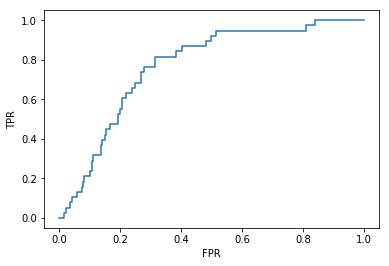

In [31]:
mlp = MLPClassifier(max_iter=2000, early_stopping=True).fit(X_resample, y_resample)
print_scores(mlp, X_resample, y_resample, X_test, y_test)
plot_roc(mlp, X_test, y_test)

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp_r = MLPRegressor(max_iter=2000, early_stopping=True).fit(X_resample, y_resample)
print_scores(mlp_r, X_resample, y_resample, X_test, y_test)
plot_roc(mlp_r, X_test, y_test)

In [ ]:
import pickle
with open('mlp_clf.pkl', 'wb') as f:
    pickle.dump(mlp, f)

In [ ]:
gs = GridSearchCV(LogisticRegression(), 
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]}, scoring="roc_auc", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(LinearSVC(), 
             param_grid=param_grid, scoring="roc_auc", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
param_grid = {'activation': ['relu', 'logistic', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate': ['constant', 'invscaling', 'adaptive'], 'tol': [0.01]}
gs = GridSearchCV(MLPClassifier(), 
             param_grid=param_grid, scoring="roc_auc", cv=4)
gs = gs.fit(X_transform, y[:3200])
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X_transform_cluster = KMeans(n_clusters=5).fit_transform(X_transform, y[:3200])

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resample_cluster, y_resample_cluster = rus.fit_sample(X_transform_cluster, y[:X_transform_cluster.shape[0]])

In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_transform_pca = PCA().fit_transform(X_transform, y[:3200])

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resample_pca, y_resample_pca = rus.fit_sample(X_transform_pca, y[:X_transform_pca.shape[0]])

In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

# t-SNE

In [ ]:
np.shape(X_transform)

In [ ]:
np.shape(y)

In [ ]:
from sklearn.manifold import TSNE
import time

In [ ]:
n_sne = 3200
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=500)
tsne_results = tsne.fit_transform(X_transform)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
import pandas as pd
df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['labels'] = y[:3200]

In [ ]:
from plotnine import *
theme_set(theme_bw())
(ggplot(df_tsne, aes(x='x', y='y', color='labels')) 
 + geom_point()
 + xlab("t-SNE-x") + ylab("t-SNE-y") + ggtitle("doc embedding t-SNE")
 + scale_color_manual(labels = (True, False), values = ("pink", "purple"))

)

In [1]:
from web_app.app import summarize

In [ ]:
summarize('https://www.who.int/csr/don/04-march-2019-mers-oman/en/')